In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9624659189242049876
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6602251960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12701265782710750560
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None, multichannel=None):
    return compare_ssim(img1, img2, data_range=_range, multichannel=multichannel)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:





"""
    resNet50 model
    loading weight 
"""
import os
import warnings
from keras import layers as Layers
from keras import models as Models
from keras import utils as Utils
from keras_applications import imagenet_utils as utils

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

def get_submodules_from_kwargs(kwargs):
    backend = keras_backend
    layers = Layers
    models = Models
    utils = Utils
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape =  utils._obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x1 = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x1)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x2 = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x2, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x3 = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x3, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, [x, x1, x2, x3], name='resnet50')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = keras_utils.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path, by_name=True)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)    
        
    return model

In [4]:
model = ResNet50(input_shape=(512,512, 3), include_top=False)
model.trainable = False


model.compile(loss="mse",
                  optimizer=Adam(),
                  metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\tomsan\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:244: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
"""
    resNet as backbone with simple CNN model
"""
def resNet50asBackbone(pretrained_weights=None):
    x_input = Input(shape=(512, 512, 3), name='image_in')
    
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x_input)
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(3, (3, 3), activation='relu',padding="same")(x)
    
    x_32, x1, x2, x3 = model(x) #32 64 128 256 512
   
    #x = Conv2D(128, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x_32)#1024
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(3, (3, 3), activation='relu',padding="same")(x)
    x_64 = UpSampling2D()(x) 
    x_128 = UpSampling2D()(x_64)
    x_256 = UpSampling2D()(x_128)
    x_512 = UpSampling2D()(x_256)
    
    #x1_256 = Conv2D(128, (3, 3), activation='relu', padding="same")(x1)
    x1_256 = Conv2D(64, (3, 3), activation='relu',padding="same")(x1)
    x1_256 = Conv2D(64, (3, 3), activation='relu',padding="same")(x1_256)
    x1_256 = Conv2D(3, (3, 3), activation='relu',padding="same")(x1_256)
    x1_512 = UpSampling2D()(x1_256)
    
    x2_128 = Conv2D(64, (3, 3), activation='relu',padding="same")(x2)
    x2_128 = Conv2D(64, (3, 3), activation='relu',padding="same")(x2_128)
    x2_128 = Conv2D(3, (3, 3), activation='relu',padding="same")(x2_128)
    x2_256 = UpSampling2D()(x2_128)
    x2_512 = UpSampling2D()(x2_256)
    
    x3_64 = Conv2D(64, (3, 3), activation='relu',padding="same")(x3)
    x3_64 = Conv2D(64, (3, 3), activation='relu',padding="same")(x3_64)
    x3_64 = Conv2D(3, (3, 3), activation='relu',padding="same")(x3_64)
    x3_128 = UpSampling2D()(x3_64)
    x3_256 = UpSampling2D()(x3_128)
    x3_512 = UpSampling2D()(x3_256)
    
    y_pred = Concatenate()([x_input, x_512, x1_512, x2_512, x3_512])
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(3, (1, 1), activation='relu', padding="same")(y_pred)
    
    resNet50model = Model(inputs=x_input, outputs=y_pred)
    resNet50model.compile(loss="mse",
                  optimizer=Adam(),
                  metrics=['accuracy'])
    if(pretrained_weights):
        resNet50model.load_weights(pretrained_weights)
    return resNet50model
#https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer


In [5]:
"""
    load training data
"""
import gc

dataY = np.zeros((4000,512, 512, 3))

count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + ".png")
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
                 
dataY = dataY.reshape(-1, 512, 512, 3)
dataY = dataY.astype('float32') / 255

In [6]:
"""
    noise image
"""
X = np.zeros((4000,512, 512, 3))
count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out50.png")
    X[count] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out60.png")
    X[count+1] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out70.png")
    X[count+2] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out80.png")
    X[count+3] = img
    img = cv2.imread("../../div2k_train_gray_out/" + picture + "_out90.png")
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 3)
X = X.astype('float32') / 255
                 
#X_train, X_test, y_train, y_test = train_test_split(X, dataY, test_size=0.3, random_state=41)

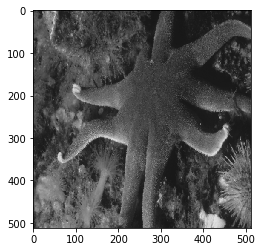

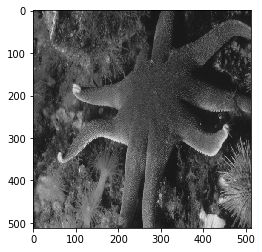

30.315876007080078


In [8]:
X_train = X.reshape(-1, 512, 512, 3)
y_train = dataY.reshape(-1, 512, 512, 3)
img = X_train[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], X_train[1]) )

In [19]:
resNet50 = resNet50asBackbone()
print(resNet50.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 512, 512, 64) 1792        image_in[0][0]                   
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 512, 512, 3)  1731        conv2d_63[0][0]                  
__________________________________________________________________________________________________
resnet50 (

In [20]:
modelCheck = ModelCheckpoint('backbone_afterGauss_v3_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()

resNet50.fit(X, dataY,
            batch_size=1,
            epochs=500,
            verbose=1,
            validation_split=0.3,
            callbacks=[modelCheck, history])
#0.0018
#0.2404

Train on 2800 samples, validate on 1200 samples
Epoch 1/500
2800/2800 [==============================] - 323s 115ms/step - loss: 0.0057 - acc: 0.3686 - val_loss: 0.0022 - val_acc: 0.1035
Epoch 2/500
2800/2800 [==============================] - 318s 114ms/step - loss: 0.0022 - acc: 0.3569 - val_loss: 0.0021 - val_acc: 0.2842
Epoch 3/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0021 - acc: 0.3404 - val_loss: 0.0022 - val_acc: 0.1902
Epoch 4/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0021 - acc: 0.3381 - val_loss: 0.0020 - val_acc: 0.2299
Epoch 5/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0020 - acc: 0.3246 - val_loss: 0.0023 - val_acc: 0.2833
Epoch 6/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0021 - acc: 0.2940 - val_loss: 0.0020 - val_acc: 0.1831
Epoch 7/500
2800/2800 [==============================] - 317s 113ms/step - loss: 0.0020 - acc: 0.2948 - val_loss: 0.00

2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.6240 - val_loss: 0.0018 - val_acc: 0.6056
Epoch 118/500
2800/2800 [==============================] - 317s 113ms/step - loss: 0.0018 - acc: 0.6081 - val_loss: 0.0018 - val_acc: 0.9975
Epoch 119/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.5675 - val_loss: 0.0018 - val_acc: 0.3375
Epoch 120/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.6614 - val_loss: 0.0018 - val_acc: 0.3450
Epoch 121/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7316 - val_loss: 0.0018 - val_acc: 0.5059
Epoch 122/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.6594 - val_loss: 0.0018 - val_acc: 0.4002
Epoch 123/500
2800/2800 [==============================] - 317s 113ms/step - loss: 0.0018 - acc: 0.6075 - val_loss: 0.0018 - val_acc: 0.9899
Epoch 124/500
2800/2800 [==

2800/2800 [==============================] - 315s 113ms/step - loss: 0.0018 - acc: 0.6896 - val_loss: 0.0018 - val_acc: 0.4883
Epoch 234/500
2800/2800 [==============================] - 315s 113ms/step - loss: 0.0018 - acc: 0.6926 - val_loss: 0.0018 - val_acc: 0.7698
Epoch 235/500
2800/2800 [==============================] - 315s 112ms/step - loss: 0.0018 - acc: 0.7409 - val_loss: 0.0018 - val_acc: 0.5768
Epoch 236/500
2800/2800 [==============================] - 314s 112ms/step - loss: 0.0018 - acc: 0.7055 - val_loss: 0.0018 - val_acc: 0.8091
Epoch 237/500
2800/2800 [==============================] - 314s 112ms/step - loss: 0.0018 - acc: 0.7170 - val_loss: 0.0018 - val_acc: 0.8204
Epoch 238/500
2800/2800 [==============================] - 314s 112ms/step - loss: 0.0018 - acc: 0.7308 - val_loss: 0.0018 - val_acc: 0.8799
Epoch 239/500
2800/2800 [==============================] - 314s 112ms/step - loss: 0.0018 - acc: 0.6853 - val_loss: 0.0018 - val_acc: 0.7449
Epoch 240/500
2800/2800 [==

2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7252 - val_loss: 0.0018 - val_acc: 0.7144
Epoch 350/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7003 - val_loss: 0.0018 - val_acc: 0.5035
Epoch 351/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7910 - val_loss: 0.0018 - val_acc: 0.1408
Epoch 352/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7091 - val_loss: 0.0018 - val_acc: 0.9831
Epoch 353/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7451 - val_loss: 0.0018 - val_acc: 0.7870
Epoch 354/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7713 - val_loss: 0.0018 - val_acc: 0.9925
Epoch 355/500
2800/2800 [==============================] - 316s 113ms/step - loss: 0.0018 - acc: 0.7190 - val_loss: 0.0018 - val_acc: 0.7992
Epoch 356/500
2800/2800 [==

2800/2800 [==============================] - 315s 112ms/step - loss: 0.0018 - acc: 0.7127 - val_loss: 0.0018 - val_acc: 0.7558
Epoch 466/500
2800/2800 [==============================] - 326s 116ms/step - loss: 0.0018 - acc: 0.7061 - val_loss: 0.0018 - val_acc: 0.9913
Epoch 467/500
2800/2800 [==============================] - 324s 116ms/step - loss: 0.0018 - acc: 0.7305 - val_loss: 0.0018 - val_acc: 0.8313
Epoch 468/500
2800/2800 [==============================] - 331s 118ms/step - loss: 0.0018 - acc: 0.6801 - val_loss: 0.0018 - val_acc: 0.9546
Epoch 469/500
2800/2800 [==============================] - 328s 117ms/step - loss: 0.0018 - acc: 0.7007 - val_loss: 0.0018 - val_acc: 0.3524
Epoch 470/500
2800/2800 [==============================] - 334s 119ms/step - loss: 0.0018 - acc: 0.7126 - val_loss: 0.0018 - val_acc: 0.7690
Epoch 471/500
2800/2800 [==============================] - 334s 119ms/step - loss: 0.0018 - acc: 0.6865 - val_loss: 0.0018 - val_acc: 0.9830
Epoch 472/500
2800/2800 [==

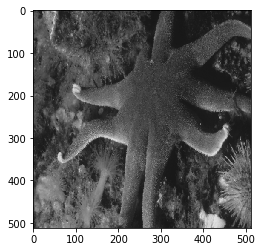

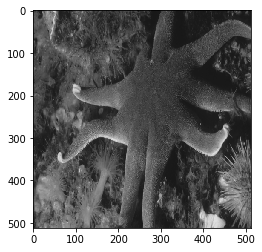

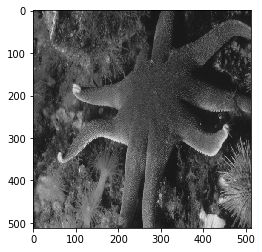

30.315876007080078
31.02454662322998
28.198599393069745
29.45643211901188
0.855602974108745
0.8759478590252311


In [21]:
result = resNet50.predict(X,  batch_size=1)
X_train = X
y_train = dataY
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()
print(PSNR(y_train[1], X_train[1]) )
print(PSNR(y_train[1], result[1]) )

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], X_train[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalPSNR = 0
for i in range(4000):
    totalPSNR += PSNR(y_train[i], result[i])
#print(totalPSNR)
print(totalPSNR / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], X_train[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)

totalSSIM = 0
for i in range(4000):
    totalSSIM += SSIM(y_train[i], result[i], 1.0, multichannel=True)
#print(totalSSIM)
print(totalSSIM / 4000)


In [7]:



"""
    load weight to see whats coming out of resnet
"""
def modelLoadWeight(pretrained_weights=None):
    x_input = Input(shape=(512, 512, 3), name='image_in')
    
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x_input)
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(3, (3, 3), activation='relu',padding="same")(x)
    
    x_32, x1, x2, x3 = model(x) #32 64 128 256 512
   
    #x = Conv2D(128, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x_32)#1024
    x = Conv2D(64, (3, 3), activation='relu',padding="same")(x)
    x = Conv2D(3, (3, 3), activation='relu',padding="same")(x)
    x_64 = UpSampling2D()(x) 
    x_128 = UpSampling2D()(x_64)
    x_256 = UpSampling2D()(x_128)
    x_512 = UpSampling2D()(x_256)
    
    #x1_256 = Conv2D(128, (3, 3), activation='relu', padding="same")(x1)
    x1_256 = Conv2D(64, (3, 3), activation='relu',padding="same")(x1)
    x1_256 = Conv2D(64, (3, 3), activation='relu',padding="same")(x1_256)
    x1_256 = Conv2D(3, (3, 3), activation='relu',padding="same")(x1_256)
    x1_512 = UpSampling2D()(x1_256)
    
    x2_128 = Conv2D(64, (3, 3), activation='relu',padding="same")(x2)
    x2_128 = Conv2D(64, (3, 3), activation='relu',padding="same")(x2_128)
    x2_128 = Conv2D(3, (3, 3), activation='relu',padding="same")(x2_128)
    x2_256 = UpSampling2D()(x2_128)
    x2_512 = UpSampling2D()(x2_256)
    
    x3_64 = Conv2D(64, (3, 3), activation='relu',padding="same")(x3)
    x3_64 = Conv2D(64, (3, 3), activation='relu',padding="same")(x3_64)
    x3_64 = Conv2D(3, (3, 3), activation='relu',padding="same")(x3_64)
    x3_128 = UpSampling2D()(x3_64)
    x3_256 = UpSampling2D()(x3_128)
    x3_512 = UpSampling2D()(x3_256)
    
    y_pred = Concatenate()([x_input, x_512, x1_512, x2_512, x3_512])
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(64, (3, 3), activation='relu', padding="same")(y_pred)
    y_pred = Conv2D(3, (1, 1), activation='relu', padding="same")(y_pred)
    
    resNet50model = Model(inputs=x_input, outputs=[y_pred, x_512, x1_512, x2_512, x3_512])
    resNet50model.compile(loss="mse",
                  optimizer=Adam(),
                  metrics=['accuracy'])
    if(pretrained_weights):
        resNet50model.load_weights(pretrained_weights, by_name=True)
    return resNet50model
#https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_in (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 512, 512, 64) 1792        image_in[0][0]                   
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_161[0][0]                 
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 512, 512, 3)  1731        conv2d_162[0][0]                 
__________________________________________________________________________________________________
resnet50 (

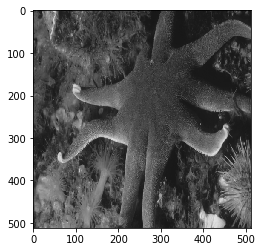

In [17]:
test = resNet50asBackbone("backbone_afterGauss_v3_0496.h5")
print(test.summary())
resu = test.predict(X[:10], batch_size=1)
img1 = resu[1] #result
plt.imshow(img1)
plt.show()

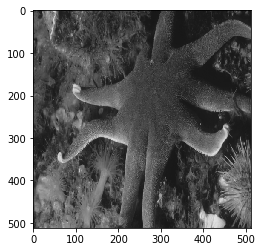

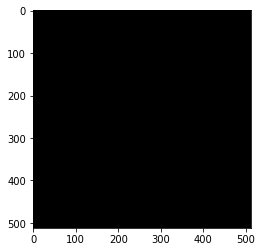

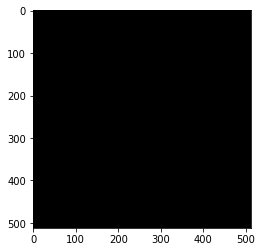

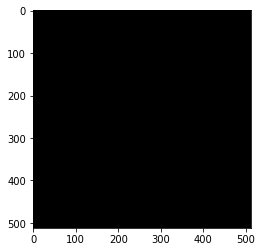

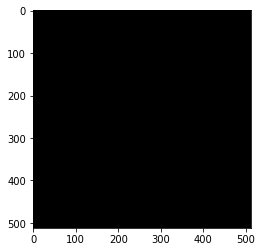

In [28]:
weights_list = test.get_weights()

loadWeight = modelLoadWeight()
loadWeight.set_weights(weights_list)

y_pred, x_512, x1_512, x2_512, x3_512 = loadWeight.predict(X[:10],  batch_size=1)
#x_512 = stage 4
#x1~3 = stage 1~3
img1 = y_pred[1] #result
plt.imshow(img1)
plt.show()
img2 = x_512[1] #stage 4
plt.imshow(img2)
plt.show()
img3 = x1_512[1] #stage 1
plt.imshow(img3)
plt.show()
img4 = x2_512[1] #stage 2
plt.imshow(img4)
plt.show()
img5 = x3_512[1] #stage 3
plt.imshow(img5)
plt.show()
